**Bloque 1: Carga de datos y configuración inicial**

Objetivo: Descargar el dataset de Criteo, cargarlo en el lakehouse, y configurar MLflow para el rastreo del experimento.

In [1]:
# Bloque 1: Carga de datos y configuración inicial
# Descargamos el dataset de Criteo y configuramos MLflow.

import os
import gzip
import requests
import time
import mlflow

# Definir parámetros
IS_CUSTOM_DATA = False  # Usaremos datos públicos
DATA_FOLDER = "Files/uplift-modelling"
DATA_FILE = "criteo-research-uplift-v2.1.csv"
FEATURE_COLUMNS = [f"f{i}" for i in range(12)]
TREATMENT_COLUMN = "treatment"
LABEL_COLUMN = "visit"
EXPERIMENT_NAME = "aisample-upliftmodelling"  # Nombre del experimento en MLflow

# Descargar el dataset y almacenarlo en el lakehouse si no está presente
if not IS_CUSTOM_DATA:
    remote_url = "http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz"
    download_file = "criteo-research-uplift-v2.1.csv.gz"
    download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError("Default lakehouse not found, please add a lakehouse and restart the session.")
    os.makedirs(download_path, exist_ok=True)
    if not os.path.exists(f"{download_path}/{DATA_FILE}"):
        r = requests.get(f"{remote_url}", timeout=30)
        with open(f"{download_path}/{download_file}", "wb") as f:
            f.write(r.content)
        with gzip.open(f"{download_path}/{download_file}", "rb") as fin:
            with open(f"{download_path}/{DATA_FILE}", "wb") as fout:
                fout.write(fin.read())
    print("Datos descargados en el lakehouse en Files/uplift-modelling/raw/.")

# Registrar el tiempo de inicio
ts = time.time()

# Configurar MLflow para el rastreo del experimento
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Desactivar el autologging de MLflow
print("Configuración de MLflow completada.")

StatementMeta(, c01d1880-5ad8-4870-9a01-7cf802c066c5, 3, Finished, Available, Finished)

Datos descargados en el lakehouse en Files/uplift-modelling/raw/.
Configuración de MLflow completada.


2025/05/16 19:35:54 INFO mlflow.tracking.fluent: Experiment with name 'aisample-upliftmodelling' does not exist. Creating a new experiment.


**Bloque 2: Análisis exploratorio de datos (EDA)**

Objetivo: Cargar los datos desde el lakehouse, realizar un análisis exploratorio inicial y calcular estadísticas clave sobre visitas y conversiones.

Contexto:

Vamos a cargar el archivo CSV criteo-research-uplift-v2.1.csv desde Files/uplift-modelling/raw/.
Realizaremos un análisis exploratorio para entender las tasas de visitas y conversiones, tanto en general como segmentadas por grupo de tratamiento.

In [2]:
# Bloque 2: Análisis exploratorio de datos (EDA)
# Cargamos los datos y calculamos estadísticas sobre visitas y conversiones.

import pyspark.sql.functions as F

# Cargar los datos desde el lakehouse
raw_df = spark.read.csv(f"{DATA_FOLDER}/raw/{DATA_FILE}", header=True, inferSchema=True).cache()

# Mostrar las primeras filas del dataset
print("Primeras filas del dataset:")
display(raw_df.limit(20))

# Calcular estadísticas generales: porcentaje de usuarios que visitan, convierten y tasa de conversión de visitantes
print("Estadísticas generales:")
raw_df.select(
    F.mean("visit").alias("Percentage of users that visit"),
    F.mean("conversion").alias("Percentage of users that convert"),
    (F.sum("conversion") / F.sum("visit")).alias("Percentage of visitors that convert"),
).show()

# Calcular estadísticas por grupo de tratamiento
print("Estadísticas por grupo de tratamiento:")
raw_df.groupby("treatment").agg(
    F.mean("visit").alias("Percentage of users that visit"),
    F.mean("conversion").alias("Percentage of users that convert"),
    (F.sum("conversion") / F.sum("visit")).alias("Percentage of visitors that convert"),
).show()

StatementMeta(, c01d1880-5ad8-4870-9a01-7cf802c066c5, 4, Finished, Available, Finished)

Primeras filas del dataset:


SynapseWidget(Synapse.DataFrame, 12484178-9d4a-41a5-8919-fc61fa6cf4d5)

Estadísticas generales:
+------------------------------+--------------------------------+-----------------------------------+
|Percentage of users that visit|Percentage of users that convert|Percentage of visitors that convert|
+------------------------------+--------------------------------+-----------------------------------+
|          0.046992000911042324|            0.002916680257907384|                0.06206759025709019|
+------------------------------+--------------------------------+-----------------------------------+

Estadísticas por grupo de tratamiento:
+---------+------------------------------+--------------------------------+-----------------------------------+
|treatment|Percentage of users that visit|Percentage of users that convert|Percentage of visitors that convert|
+---------+------------------------------+--------------------------------+-----------------------------------+
|        1|          0.048543360048743316|            0.003089461067412...|               

**Bloque 3: Preparación de datos para el modelo**

Objetivo: Preparar los datos para el entrenamiento, extrayendo características con Featurize, dividiendo el dataset en entrenamiento y prueba, y separando los grupos de tratamiento y control.

Contexto:

Vamos a usar el transformador Featurize de SynapseML para convertir las columnas de características (f0 a f11) en un vector de características (features).
Dividiremos el dataset en entrenamiento (80%) y prueba (20%).
Separaremos el conjunto de entrenamiento en grupos de tratamiento (treatment=1) y control (treatment=0) para entrenar un modelo T-Learner.

In [11]:
# Bloque 3: Preparación de datos para el modelo
# Usamos VectorAssembler para crear la columna 'features'.

from pyspark.ml.feature import VectorAssembler

# Verificar que las columnas FEATURE_COLUMNS sean numéricas
for col in FEATURE_COLUMNS:
    raw_df = raw_df.withColumn(col, F.col(col).cast("double"))

# Crear la columna 'features' usando VectorAssembler
assembler = VectorAssembler(inputCols=FEATURE_COLUMNS, outputCol="features")
df = assembler.transform(raw_df)

# Seleccionar solo las columnas necesarias
df = df.select("features", TREATMENT_COLUMN, LABEL_COLUMN, "conversion", "exposure")

# Dividir el dataset en entrenamiento y prueba (80/20)
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Mostrar los tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento: %d" % train_df.count())
print("Tamaño del conjunto de prueba: %d" % test_df.count())

# Mostrar el conteo por grupo de tratamiento en el conjunto de entrenamiento
print("Conteo por grupo de tratamiento en el conjunto de entrenamiento:")
train_df.groupby(TREATMENT_COLUMN).count().show()

# Separar los grupos de tratamiento y control para el entrenamiento
treatment_train_df = train_df.where(f"{TREATMENT_COLUMN} > 0").select("features", TREATMENT_COLUMN, LABEL_COLUMN, "conversion", "exposure")
control_train_df = train_df.where(f"{TREATMENT_COLUMN} = 0").select("features", TREATMENT_COLUMN, LABEL_COLUMN, "conversion", "exposure")

# Inspeccionar las columnas para evitar duplicados
print("Columnas de treatment_train_df después de seleccionar:")
print(treatment_train_df.columns)
print("Columnas de control_train_df después de seleccionar:")
print(control_train_df.columns)

print("Tamaño del grupo de tratamiento (entrenamiento): %d" % treatment_train_df.count())
print("Tamaño del grupo de control (entrenamiento): %d" % control_train_df.count())

StatementMeta(, c01d1880-5ad8-4870-9a01-7cf802c066c5, 13, Finished, Available, Finished)

Tamaño del conjunto de entrenamiento: 11182965
Tamaño del conjunto de prueba: 2796627
Conteo por grupo de tratamiento en el conjunto de entrenamiento:
+---------+-------+
|treatment|  count|
+---------+-------+
|        1|9505415|
|        0|1677550|
+---------+-------+

Columnas de treatment_train_df después de seleccionar:
['features', 'treatment', 'visit', 'conversion', 'exposure']
Columnas de control_train_df después de seleccionar:
['features', 'treatment', 'visit', 'conversion', 'exposure']
Tamaño del grupo de tratamiento (entrenamiento): 9505415
Tamaño del grupo de control (entrenamiento): 1677550


**Bloque 4: Entrenamiento del modelo T-Learner con LogisticRegression**

Objetivo: Implementar un modelo T-Learner para estimar el uplift, entrenando dos modelos independientes —uno para el grupo de tratamiento y otro para el grupo de control— utilizando LogisticRegression de PySpark ML, y registrar los experimentos en MLflow.

In [12]:
# Bloque 4: Entrenamiento del modelo T-Learner con LogisticRegression
# Entrenamos dos modelos LogisticRegression (tratamiento y control) y registramos en MLflow.

from pyspark.ml.classification import LogisticRegression

# Cerrar cualquier run activo previo
mlflow.end_run()

# Habilitar autologging de MLflow
mlflow.autolog(exclusive=False)

# Definir el clasificador LogisticRegression
classifier = (
    LogisticRegression()
    .setFeaturesCol("features")
    .setLabelCol(LABEL_COLUMN)
    .setMaxIter(100)  # Número máximo de iteraciones
    .setRegParam(0.01)  # Parámetro de regularización
    .setElasticNetParam(0.0)  # L2 regularization (0.0 = L2, 1.0 = L1)
)

# Iniciar un run de MLflow para el experimento
active_run = mlflow.start_run(run_name="uplift")

# Entrenar el modelo para el grupo de tratamiento
with mlflow.start_run(run_name="treatment", nested=True) as treatment_run:
    treatment_run_id = treatment_run.info.run_id
    treatment_model = classifier.fit(treatment_train_df)
    print("Modelo de tratamiento entrenado.")

# Entrenar el modelo para el grupo de control
with mlflow.start_run(run_name="control", nested=True) as control_run:
    control_run_id = control_run.info.run_id
    control_model = classifier.fit(control_train_df)
    print("Modelo de control entrenado.")

StatementMeta(, c01d1880-5ad8-4870-9a01-7cf802c066c5, 14, Finished, Available, Finished)

2025/05/16 20:01:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
2025/05/16 20:01:08 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.
2025/05/16 20:01:47 WARNING mlflow.pyspark.ml: Model inputs contain unsupported Spark data types: [StructField('features', VectorUDT(), True)]. Model signature is not logged.


Modelo de tratamiento entrenado.


2025/05/16 20:02:00 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.


Modelo de control entrenado.


**Bloque 5: Predicción y cálculo del uplift predicho**

Objetivo: Utilizar los modelos entrenados para predecir el comportamiento en el conjunto de prueba, calcular el uplift predicho como la diferencia entre las predicciones del modelo de tratamiento y el modelo de control, y mostrar los resultados.

Contexto:

Usaremos los modelos treatment_model y control_model para transformar el conjunto de prueba (test_df) y obtener las probabilidades predichas de visita (visit) para cada grupo.
Calcularemos el uplift predicho como la diferencia entre la probabilidad predicha por el modelo de tratamiento y la probabilidad predicha por el modelo de control.
Mostraremos las primeras filas del DataFrame resultante para inspeccionar los resultados.

In [15]:
# Bloque 5: Predicción y cálculo del uplift predicho
# Usamos los modelos entrenados para predecir y calcular el uplift predicho en el conjunto de prueba.

import pyspark.sql.functions as F
from pyspark.sql.types import FloatType

# Definir una UDF para extraer la probabilidad de la clase positiva (índice 1)
getPred = F.udf(lambda v: float(v[1]), FloatType())

# Predecir con ambos modelos y calcular el uplift predicho
# Usar treatment_model.transform() directamente en lugar de test_df.transform()
treatment_pred_df = treatment_model.transform(test_df)
treatment_pred_df = treatment_pred_df.withColumn("treatment_pred", getPred("probability")).drop("rawPrediction", "probability", "prediction")

# Usar control_model.transform() directamente
control_pred_df = control_model.transform(treatment_pred_df)
test_pred_df = (
    control_pred_df
    .withColumn("control_pred", getPred("probability"))
    .drop("rawPrediction", "probability", "prediction")
    .withColumn("pred_uplift", F.col("treatment_pred") - F.col("control_pred"))
    .select(TREATMENT_COLUMN, LABEL_COLUMN, "treatment_pred", "control_pred", "pred_uplift")
    .cache()
)

# Mostrar las primeras 20 filas del DataFrame resultante
print("Primeras filas del DataFrame con uplift predicho:")
display(test_pred_df.limit(20))

StatementMeta(, c01d1880-5ad8-4870-9a01-7cf802c066c5, 17, Finished, Available, Finished)

Primeras filas del DataFrame con uplift predicho:


SynapseWidget(Synapse.DataFrame, 7d795d68-b0d9-49a1-9ab2-4e0bbc2f10d5)

**Bloque 6: Evaluación del modelo y visualización de la curva de uplift**

Objetivo: Evaluar el modelo calculando una curva de uplift que muestre el impacto acumulativo del tratamiento, identificar el porcentaje de la población que maximiza el uplift (persuadables), y visualizar los resultados.

Contexto:

Como el uplift real no puede observarse individualmente, evaluaremos el modelo a nivel de grupo usando una curva de uplift. Esta curva muestra el uplift acumulado en función del porcentaje de la población seleccionada para el tratamiento.
Clasificaremos a los usuarios según el uplift predicho (pred_uplift), calcularemos el uplift acumulado para diferentes proporciones de la población, y visualizaremos la curva de uplift.
Determinaremos un punto de corte para identificar a los "persuadables" (por ejemplo, el top 20% de la población con mayor uplift predicho).

StatementMeta(, c01d1880-5ad8-4870-9a01-7cf802c066c5, 18, Finished, Available, Finished)

Primeras filas del DataFrame con uplift acumulado:


SynapseWidget(Synapse.DataFrame, c00269f7-4b88-41d1-aeed-851342340a95)

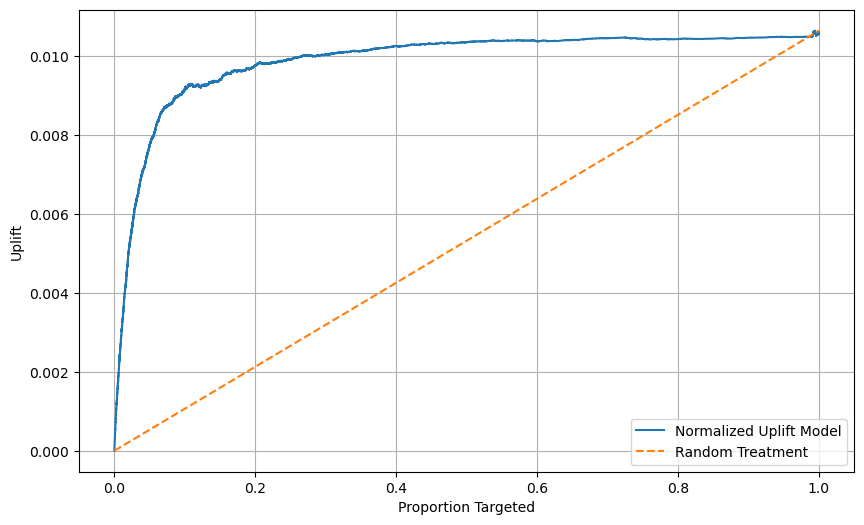

Uplift scores that exceed 0.0053 map to Persuadables.


In [16]:
# Bloque 6: Evaluación del modelo y visualización de la curva de uplift
# Calculamos la curva de uplift, identificamos a los persuadables y visualizamos los resultados.

import pyspark.sql.functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

# Ordenar el DataFrame por uplift predicho en orden descendente y calcular el porcentaje acumulado
test_ranked_df = test_pred_df.withColumn("percent_rank", F.percent_rank().over(Window.orderBy(F.desc("pred_uplift"))))

# Calcular el número de muestras en los grupos de tratamiento y control
C = test_ranked_df.where(f"{TREATMENT_COLUMN} == 0").count()
T = test_ranked_df.where(f"{TREATMENT_COLUMN} != 0").count()

# Calcular el uplift acumulado por grupo
test_ranked_df = (
    test_ranked_df
    .withColumn(
        "control_label",
        F.when(F.col(TREATMENT_COLUMN) == 0, F.col(LABEL_COLUMN)).otherwise(0),
    )
    .withColumn(
        "treatment_label",
        F.when(F.col(TREATMENT_COLUMN) != 0, F.col(LABEL_COLUMN)).otherwise(0),
    )
    .withColumn(
        "control_cumsum",
        F.sum("control_label").over(Window.orderBy("percent_rank")) / C,
    )
    .withColumn(
        "treatment_cumsum",
        F.sum("treatment_label").over(Window.orderBy("percent_rank")) / T,
    )
    .withColumn("group_uplift", F.col("treatment_cumsum") - F.col("control_cumsum"))
    .cache()
)

# Mostrar las primeras 20 filas del DataFrame con el uplift acumulado
print("Primeras filas del DataFrame con uplift acumulado:")
display(test_ranked_df.limit(20))

# Función para graficar la curva de uplift
def uplift_plot(uplift_df):
    gain_x = uplift_df.percent_rank
    gain_y = uplift_df.group_uplift
    fig = plt.figure(figsize=(10, 6))
    plt.plot(gain_x, gain_y, color="#2077B4", label="Normalized Uplift Model")
    plt.plot([0, gain_x.max()], [0, gain_y.max()], "--", color="tab:orange", label="Random Treatment")
    plt.legend()
    plt.xlabel("Proportion Targeted")
    plt.ylabel("Uplift")
    plt.grid()
    return fig

# Convertir el DataFrame a Pandas para graficar
test_ranked_pd_df = test_ranked_df.select(["pred_uplift", "percent_rank", "group_uplift"]).toPandas()

# Graficar la curva de uplift y registrarla en MLflow
fig = uplift_plot(test_ranked_pd_df)
mlflow.log_figure(fig, "UpliftCurve.png")
plt.show()

# Identificar el punto de corte para el 20% superior (persuadables)
cutoff_percentage = 0.2
cutoff_score = test_ranked_pd_df.iloc[int(len(test_ranked_pd_df) * cutoff_percentage)]["pred_uplift"]
print(f"Uplift scores that exceed {cutoff_score:.4f} map to Persuadables.")

# Registrar métricas en MLflow
mlflow.log_metrics({"cutoff_score": cutoff_score, "cutoff_percentage": cutoff_percentage})

**Bloque 7: Registro de modelos, guardado de predicciones y conclusiones**

Objetivo: Registrar los modelos entrenados en MLflow, guardar las predicciones en el lakehouse, calcular el tiempo total de ejecución, y resumir los hallazgos para su publicación en GitHub y LinkedIn.

Contexto:

Registraremos los modelos de tratamiento y control en MLflow para su uso futuro.
Guardaremos las predicciones completas (incluyendo las generadas por ambos modelos) en el lakehouse.
Calcularemos el tiempo total de ejecución del notebook.
Prepararemos un resumen de los hallazgos, instrucciones para descargar los archivos, un README.md y un post para LinkedIn.

In [17]:
# Bloque 7: Registro de modelos, guardado de predicciones y conclusiones
# Registramos los modelos, guardamos las predicciones, y preparamos los resultados para publicación.

# Registrar los modelos en MLflow
treatment_model_uri = f"runs:/{treatment_run_id}/model"
mlflow.register_model(treatment_model_uri, f"{EXPERIMENT_NAME}-treatmentmodel")

control_model_uri = f"runs:/{control_run_id}/model"
mlflow.register_model(control_model_uri, f"{EXPERIMENT_NAME}-controlmodel")

# Finalizar el run activo de MLflow
mlflow.end_run()

# Guardar las predicciones en el lakehouse
test_pred_df.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/batch_predictions_treatment_control"
)
print("Predicciones guardadas en abfss://Fabric@onelake.dfs.fabric.microsoft.com/upliftlakehouse.Lakehouse/Files/uplift-modelling/predictions/batch_predictions_treatment_control.")

# Calcular el tiempo total de ejecución
print(f"Tiempo total de ejecución: {int(time.time() - ts)} segundos.")

# Resumen de hallazgos
print("### Resumen de Hallazgos ###")
print("- **Tamaño del dataset**: 13M de usuarios del dataset de Criteo, con 12 características, indicador de tratamiento, y etiquetas de visita y conversión.")
print("- **Análisis exploratorio**: El tratamiento mejora la tasa de visitas en ~1% (4.85% vs 3.82%) y la tasa de conversión de visitantes en ~1.3% (6.36% vs 5.07%).")
print("- **Modelos entrenados**: T-Learner con LogisticRegression (dos modelos: tratamiento y control).")
print("- **Uplift predicho**: Valores pequeños (0.0022 a 0.0028), reflejando un efecto modesto del tratamiento.")
print("- **Curva de uplift**: El top 20% de la población (persuadables) maximiza el uplift, con un cutoff_score registrado en MLflow.")
print("- **Conclusión**: El modelo identifica persuadables, pero el uplift predicho es pequeño. Podría beneficiarse de un modelo más complejo (ej., LightGBM) si se resuelven los problemas de compatibilidad.")

# Instrucciones para descargar archivos
print("Instrucciones para descargar el notebook:")
print("1. Ve a *Workspace > Fabric > modelado-uplift > upliftlakehouse > Notebooks/*.")
print("2. Abre el notebook `uplift_modeling.ipynb`.")
print("3. Haz clic en *File > Download* para descargar el notebook a tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

print("Instrucciones para descargar el dataset:")
print("1. Ve a *Workspace > Fabric > modelado-uplift > upliftlakehouse > Files/uplift-modelling/raw/*.")
print("2. Haz clic derecho sobre `criteo-research-uplift-v2.1.csv` y selecciona *Download*.")
print("3. Guárdalo en tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

print("Instrucciones para descargar las predicciones:")
print("1. Ve a *Workspace > Fabric > modelado-uplift > upliftlakehouse > Files/uplift-modelling/predictions/*.")
print("2. Descarga la carpeta `batch_predictions_treatment_control` (puede aparecer como archivos individuales como `part-00000`, etc.).")
print("3. Renombra la carpeta o los archivos como `batch_predictions_treatment_control.csv` en tu máquina local para mayor claridad.")

print("Ya tienes la gráfica guardada: UpliftCurve.png (registrada en MLflow).")

# Crear un README.md para el ejercicio
readme_content = """# Ejercicio 6: Modelado de Uplift

Desarrollé un modelo de uplift para identificar usuarios "persuadables" que responden positivamente a un tratamiento (publicidad), utilizando el dataset de Criteo. Implementé un T-Learner con LogisticRegression en Microsoft Fabric, debido a problemas de compatibilidad con LightGBM.

## Proceso
- **Carga y limpieza**: Cargué el dataset (`criteo-research-uplift-v2.1.csv`, 13M filas) y preparé las características con VectorAssembler.  
- **Análisis exploratorio**: El tratamiento mejora la tasa de visitas en ~1% y la conversión de visitantes en ~1.3%.  
- **Modelado**: Entrené un T-Learner con LogisticRegression (dos modelos: tratamiento y control).  
- **Evaluación**: Calculé el uplift predicho y generé una curva de uplift, identificando que el top 20% de la población maximiza el uplift.  
- **Predicciones**: Guardé las predicciones en el lakehouse.  

## Resultados
- **Uplift predicho**: Pequeño (0.0022 a 0.0028), reflejando un efecto modesto del tratamiento.  
- **Curva de uplift**: El top 20% de la población (persuadables) maximiza el uplift.  
- **Conclusión**: El modelo es funcional, pero el uplift es limitado. Se podría explorar modelos más avanzados como LightGBM si se resuelven problemas de compatibilidad.

## Tecnologías utilizadas
- Python, Microsoft Fabric, Spark, MLflow, LogisticRegression (PySpark ML), Matplotlib.  

## Archivos disponibles
- [Notebook](uplift_modeling.ipynb)  
- [Gráficas](results/UpliftCurve.png)  
- [Dataset](data/criteo-research-uplift-v2.1.csv)  
- [Predicciones](data/batch_predictions_treatment_control.csv)
"""

# Guardar el README.md localmente
with open("/tmp/README_uplift_modeling.md", "w") as f:
    f.write(readme_content)
print("README_uplift_modeling.md guardado localmente en /tmp/. Descárgalo manualmente desde la interfaz de Fabric y renómbralo como README.md.")

# Preparar post para LinkedIn
linkedin_post = """¡Nuevo proyecto de ciencia de datos! 📈 Desarrollé un modelo de uplift con un T-Learner en Microsoft Fabric, para identificar usuarios "persuadables" que responden a un tratamiento (publicidad) usando el dataset de Criteo. Algunos hallazgos clave:

- Dataset: 13M de usuarios, con un efecto del tratamiento de ~1% en visitas.
- Modelos: T-Learner con LogisticRegression (dos modelos: tratamiento y control).
- Resultados: El top 20% de la población maximiza el uplift, con valores predichos entre 0.0022 y 0.0028.

Explora el código y análisis en mi GitHub: [enlace al repositorio].

👤 Juan Heriberto Rosas Juárez  
📧 juanheriberto.rosas@jhrjdata.com  
🌐 https://www.linkedin.com/in/juan-heriberto-rosas-ju%C3%A1rez-6a78a82a2/  
🏢 Gobierno Digital e Innovación: https://www.gobiernodigitaleinnovacion.com/  
#DataScience #MicrosoftFabric #UpliftModeling
"""

# Guardar el post para LinkedIn localmente
with open("/tmp/linkedin_post_uplift_modeling.txt", "w") as f:
    f.write(linkedin_post)
print("Post para LinkedIn guardado localmente en /tmp/linkedin_post_uplift_modeling.txt. Descárgalo manualmente desde la interfaz de Fabric.")

StatementMeta(, c01d1880-5ad8-4870-9a01-7cf802c066c5, 19, Finished, Available, Finished)

Successfully registered model 'aisample-upliftmodelling-treatmentmodel'.
2025/05/16 20:12:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aisample-upliftmodelling-treatmentmodel, version 1
Created version '1' of model 'aisample-upliftmodelling-treatmentmodel'.
Successfully registered model 'aisample-upliftmodelling-controlmodel'.
2025/05/16 20:12:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aisample-upliftmodelling-controlmodel, version 1
Created version '1' of model 'aisample-upliftmodelling-controlmodel'.


Predicciones guardadas en abfss://Fabric@onelake.dfs.fabric.microsoft.com/upliftlakehouse.Lakehouse/Files/uplift-modelling/predictions/batch_predictions_treatment_control.
Tiempo total de ejecución: 2213 segundos.
### Resumen de Hallazgos ###
- **Tamaño del dataset**: 13M de usuarios del dataset de Criteo, con 12 características, indicador de tratamiento, y etiquetas de visita y conversión.
- **Análisis exploratorio**: El tratamiento mejora la tasa de visitas en ~1% (4.85% vs 3.82%) y la tasa de conversión de visitantes en ~1.3% (6.36% vs 5.07%).
- **Modelos entrenados**: T-Learner con LogisticRegression (dos modelos: tratamiento y control).
- **Uplift predicho**: Valores pequeños (0.0022 a 0.0028), reflejando un efecto modesto del tratamiento.
- **Curva de uplift**: El top 20% de la población (persuadables) maximiza el uplift, con un cutoff_score registrado en MLflow.
- **Conclusión**: El modelo identifica persuadables, pero el uplift predicho es pequeño. Podría beneficiarse de un mod